In [12]:
import numpy as np
import pandas as pd
import os
import glob
from stat_analysis import *
from analysis_helper import *
from IPython.display import clear_output

iter_max=10
task_col='pcba-aid624173'
cluster_col='BT_0.4 ID'

run_threshold=5
hs_params, benchmark_params, custom_params = 70, 4, 4
hs_job_count = hs_params*3*10
benchmark_job_count = benchmark_params*3*10 
custom_job_count = custom_params*3*10

hs_dir = glob.glob('../../../aldd_results/aldd_exp_1_final/params_results_hs/*/*/*/*/')
custom_dir = glob.glob('../../../aldd_results/aldd_exp_1_final/params_results_custom_cbws/*/*/*/*/')
benchmark_dir = glob.glob('../../../aldd_results/aldd_exp_1_final/params_results_benchmarks/*/*/*/*/')

In [13]:
all_96_hs, all_384_hs, all_1536_hs, all_df_hs, successful_jobs, failed_jobs = get_results(hs_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('HS Jobs:')
print('Total jobs: {}'.format(hs_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(hs_job_count - len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(hs_params))
print('Successful HS: {}'.format(len(hs_unique)))

hs_ids_0 = all_96_hs['hs_id'].unique()
hs_ids_1 = all_384_hs['hs_id'].unique()
hs_ids_2 = all_1536_hs['hs_id'].unique()

overlap_hs_ids = np.intersect1d(np.intersect1d(hs_ids_0, hs_ids_1), hs_ids_2)
unioned_hs_ids = np.union1d(np.union1d(hs_ids_0, hs_ids_1), hs_ids_2)
print('HS success by batch size:')
print('Successful HS batch size 96: {}.'.format(hs_ids_0.shape[0]))
print('Successful HS batch size 384: {}.'.format(hs_ids_1.shape[0]))
print('Successful HS batch size 1536: {}.'.format(hs_ids_2.shape[0]))
print('Successful HS intersection batch sizes: {}.'.format(overlap_hs_ids.shape[0]))
print('Successful HS union batch sizes: {}.'.format(unioned_hs_ids.shape[0]))

----------------------------------------------------------------------------
HS Jobs:
Total jobs: 2100
Successful jobs: 803
Failed jobs: 1297
Total HS: 70
Successful HS: 62
HS success by batch size:
Successful HS batch size 96: 56.
Successful HS batch size 384: 25.
Successful HS batch size 1536: 2.
Successful HS intersection batch sizes: 2.
Successful HS union batch sizes: 56.


In [14]:
all_96_bm, all_384_bm, all_1536_bm, all_df_bm, successful_jobs, failed_jobs = get_results(benchmark_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('Benchmark Jobs:')
print('Total jobs: {}'.format(benchmark_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(benchmark_job_count - len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(benchmark_params))
print('Successful HS: {}'.format(len(hs_unique)))

hs_ids_0 = all_96_bm['hs_id'].unique()
hs_ids_1 = all_384_bm['hs_id'].unique()
hs_ids_2 = all_1536_bm['hs_id'].unique()

overlap_hs_ids = np.intersect1d(np.intersect1d(hs_ids_0, hs_ids_1), hs_ids_2)
unioned_hs_ids = np.union1d(np.union1d(hs_ids_0, hs_ids_1), hs_ids_2)
print('HS success by batch size:')
print('Successful HS batch size 96: {}.'.format(hs_ids_0.shape[0]))
print('Successful HS batch size 384: {}.'.format(hs_ids_1.shape[0]))
print('Successful HS batch size 1536: {}.'.format(hs_ids_2.shape[0]))
print('Successful HS intersection batch sizes: {}.'.format(overlap_hs_ids.shape[0]))
print('Successful HS union batch sizes: {}.'.format(unioned_hs_ids.shape[0]))

----------------------------------------------------------------------------
Benchmark Jobs:
Total jobs: 120
Successful jobs: 94
Failed jobs: 26
Total HS: 4
Successful HS: 4
HS success by batch size:
Successful HS batch size 96: 4.
Successful HS batch size 384: 4.
Successful HS batch size 1536: 0.
Successful HS intersection batch sizes: 0.
Successful HS union batch sizes: 4.


In [15]:
all_96_cs, all_384_cs, all_1536_cs, all_df_cs, successful_jobs, failed_jobs = get_results(custom_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('Custom Jobs:')
print('Total jobs: {}'.format(custom_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(custom_job_count - len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:3]) for x in successful_jobs])
print('Total HS: {}'.format(custom_params))
print('Successful HS: {}'.format(len(hs_unique)))

hs_ids_0 = all_96_cs['hs_id'].unique()
hs_ids_1 = all_384_cs['hs_id'].unique()
hs_ids_2 = np.array([])

overlap_hs_ids = np.intersect1d(np.intersect1d(hs_ids_0, hs_ids_1), hs_ids_2)
unioned_hs_ids = np.union1d(np.union1d(hs_ids_0, hs_ids_1), hs_ids_2)
print('HS success by batch size:')
print('Successful HS batch size 96: {}.'.format(hs_ids_0.shape[0]))
print('Successful HS batch size 384: {}.'.format(hs_ids_1.shape[0]))
print('Successful HS batch size 1536: {}.'.format(hs_ids_2.shape[0]))
print('Successful HS intersection batch sizes: {}.'.format(overlap_hs_ids.shape[0]))
print('Successful HS union batch sizes: {}.'.format(unioned_hs_ids.shape[0]))

----------------------------------------------------------------------------
Custom Jobs:
Total jobs: 120
Successful jobs: 39
Failed jobs: 81
Total HS: 4
Successful HS: 2
HS success by batch size:
Successful HS batch size 96: 2.
Successful HS batch size 384: 2.
Successful HS batch size 1536: 0.
Successful HS intersection batch sizes: 0.
Successful HS union batch sizes: 2.


---
# Normality, Homoscedasticity (equality of variance)

In [16]:
import pingouin as pg

all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
display(pg.normality(all_96, dv='total_unique_hits', group='hs_id'))
display(pg.homoscedasticity(all_96, dv='total_unique_hits', group='hs_id'))

print('Some strategies fail normality constraint test.')
print('Also equivalence of variance test fails.')
print('Also unequal sample sizes since some runs did not complete. Will set unfinished runs to mean of completed runs.')
print('So opt to use non-parametric test.')

,W,pval,normal
CBWS_custom_1,0.793566,0.017239,False
CBWS_custom_2,0.738062,0.002554,False
MABSelector_1,0.772076,0.006629,False
MABSelector_2,0.751705,0.003743,False
MABSelector_3,0.743856,0.003004,False
...,...,...,...
CBWS_668,0.639764,0.000165,False
CBWS_715,0.919227,0.350556,True
CBWS_719,0.919227,0.350556,True
CBWS_762,0.887604,0.188491,True


,W,pval,equal_var
levene,2.053994,0.000016,False


Some strategies fail normality constraint test.
Also equivalence of variance test fails.
Also unequal sample sizes since some runs did not complete. Will set unfinished runs to mean of completed runs.
So opt to use non-parametric test.


---
# Top models for batch_size=96

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


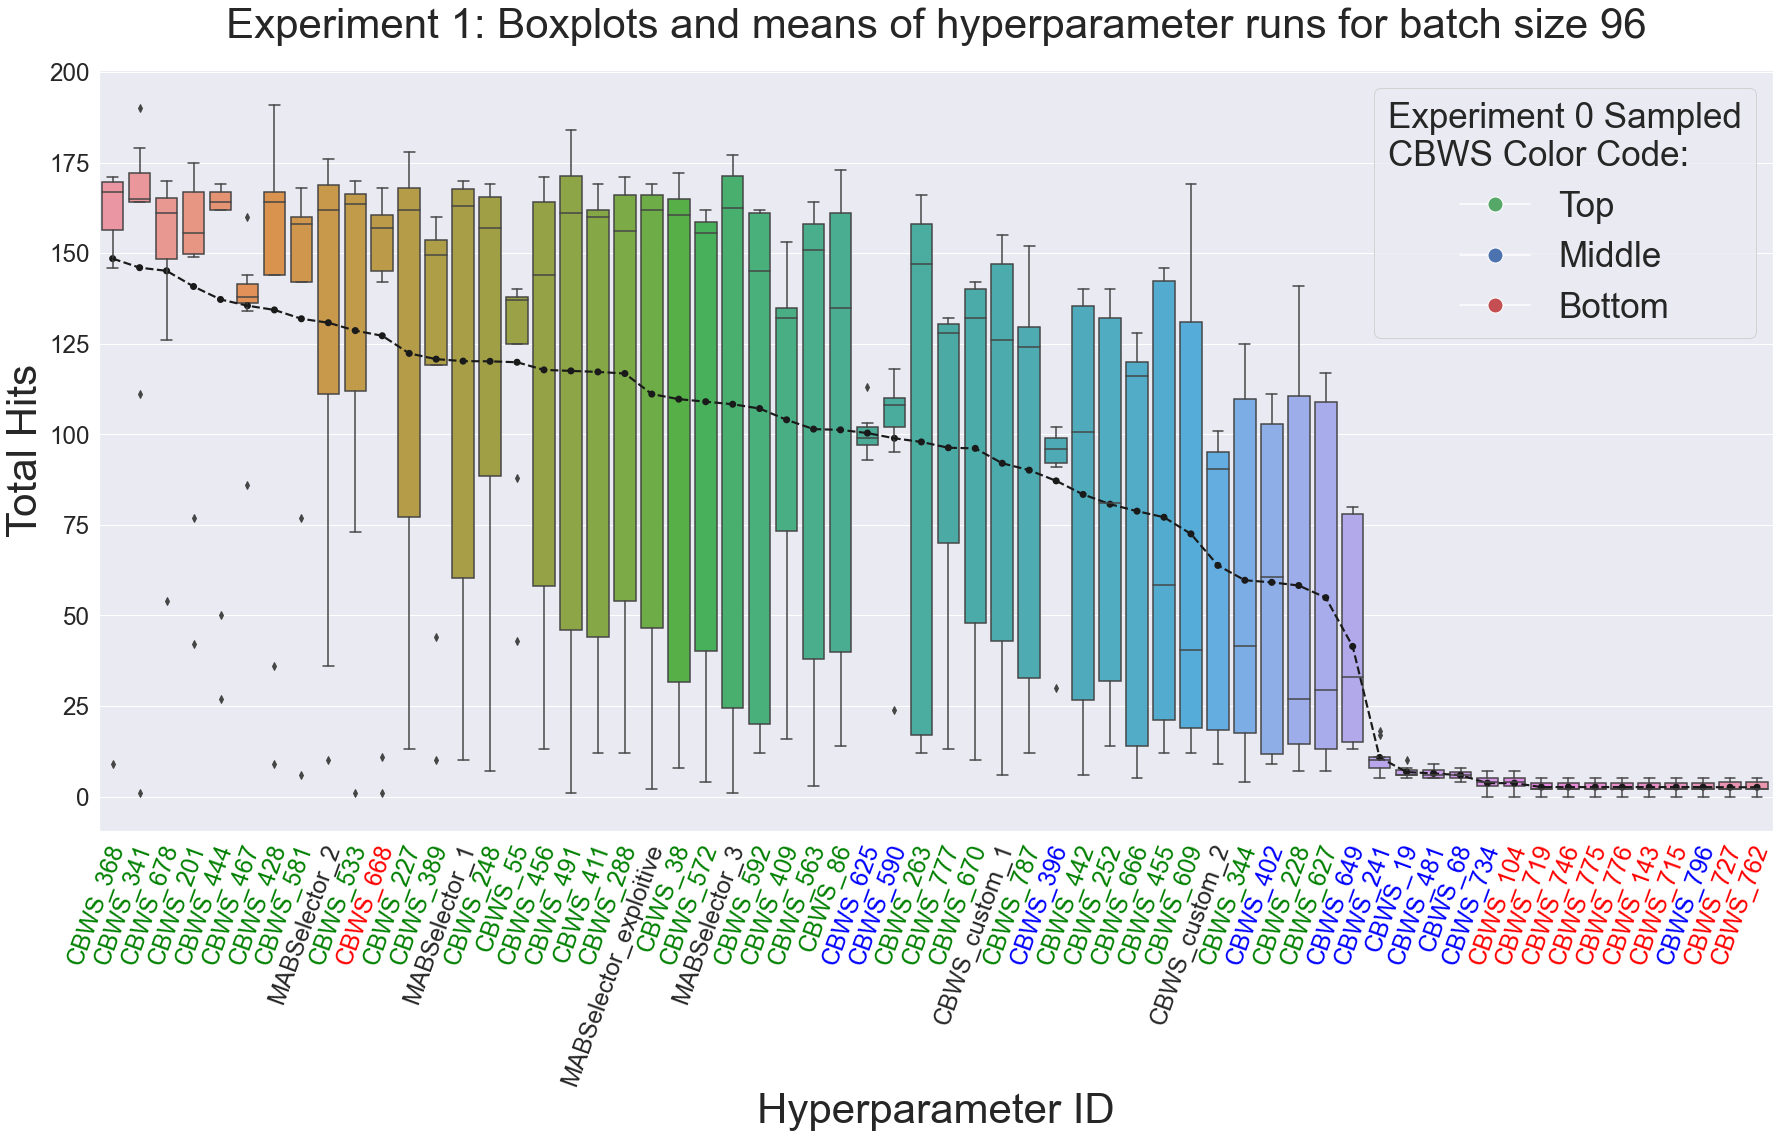

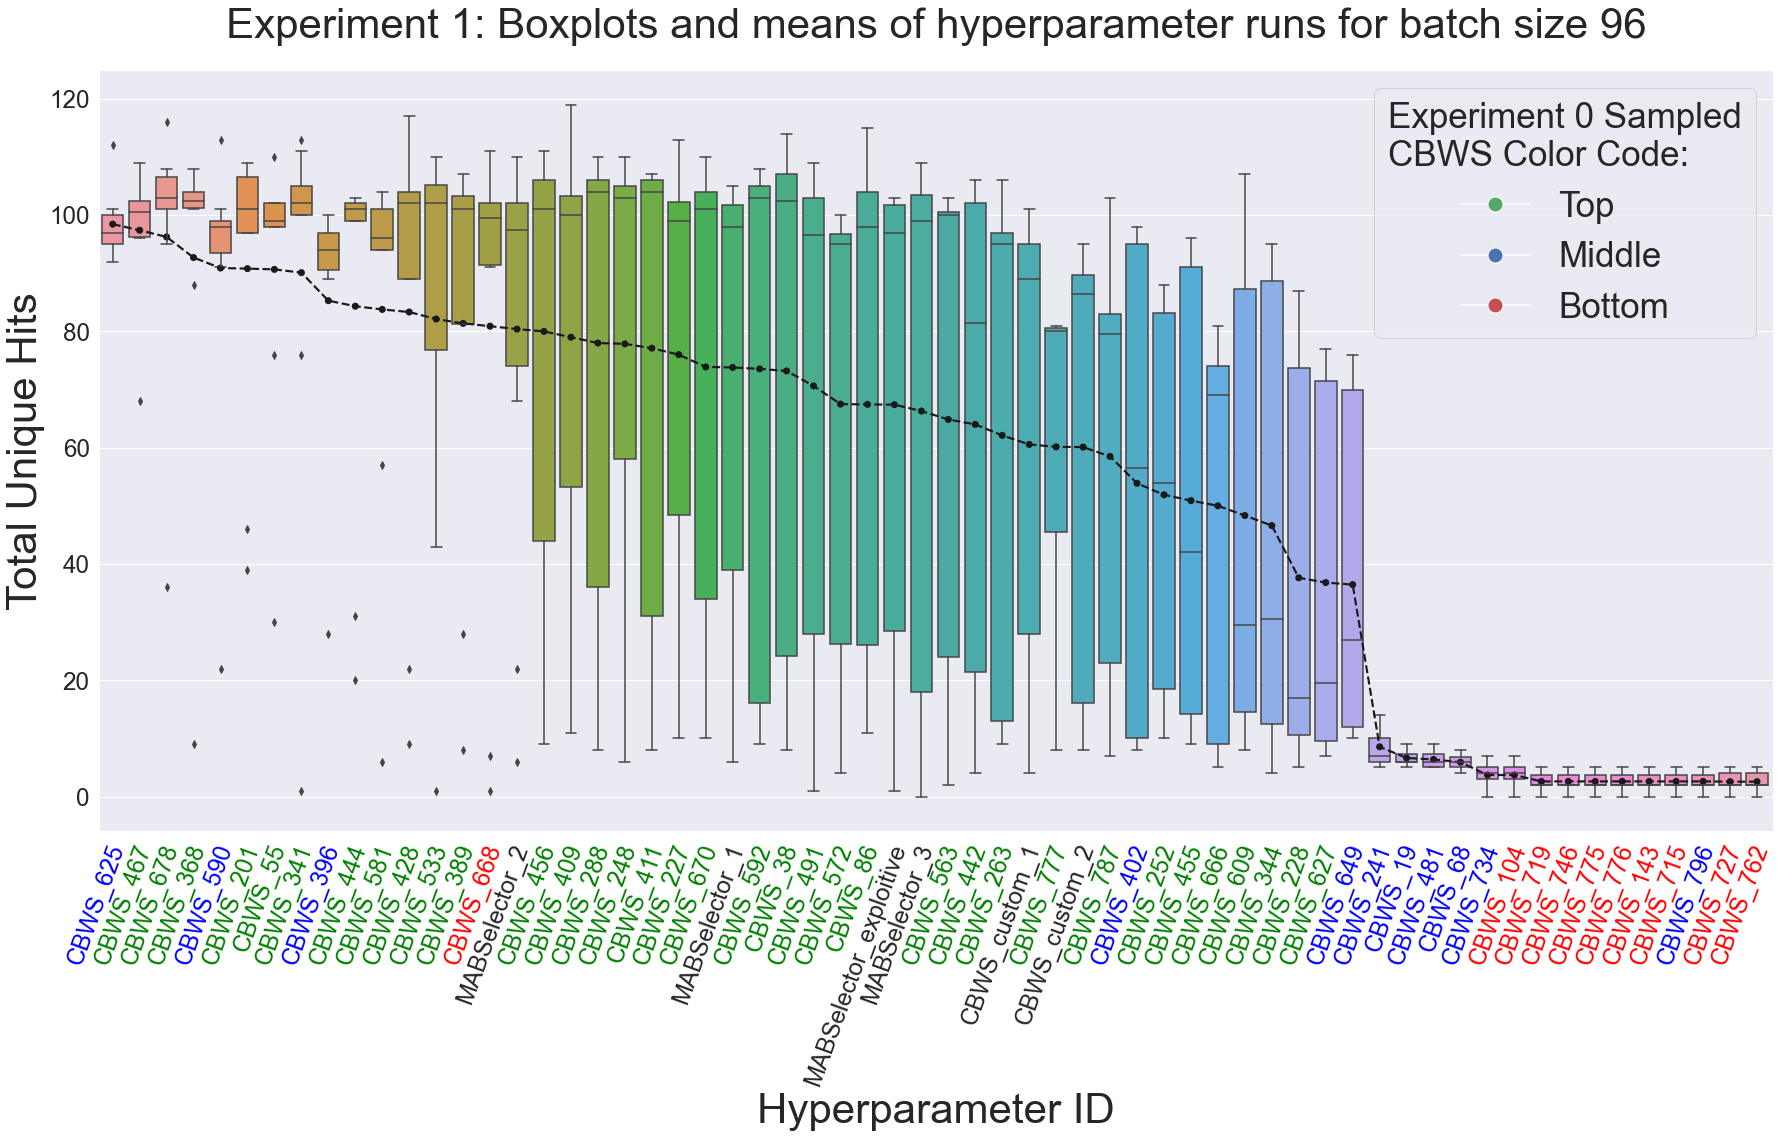

In [81]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_96_hs = get_top_summary(all_96_hs)
top_96_bm = get_top_summary(all_96_bm)
top_96_cs = get_top_summary(all_96_cs)

from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2.2)
%load_ext autoreload
%autoreload 2

fontsize=42
all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
top_96_all = pd.concat([top_96_cs, top_96_bm, top_96_hs])
plot_boxplots_simple(all_96, top_96_all, metric_col_box='total_hits', metric_col_point='total_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 96',
                     xlabel='Hyperparameter ID', ylabel='Total Hits', isExp1=True, fontsize=fontsize)
plot_boxplots_simple(all_96, top_96_all, metric_col_box='total_unique_hits', metric_col_point='total_unique_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 96',
                     xlabel='Hyperparameter ID', ylabel='Total Unique Hits', isExp1=True, fontsize=fontsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmp2xlNsN\filed6fc6518151d', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Hits Corrected Friedman's chi-squared statistic: 4.12871307169918. DoF: 46.0. p-value: 3.3306690738754696e-15.


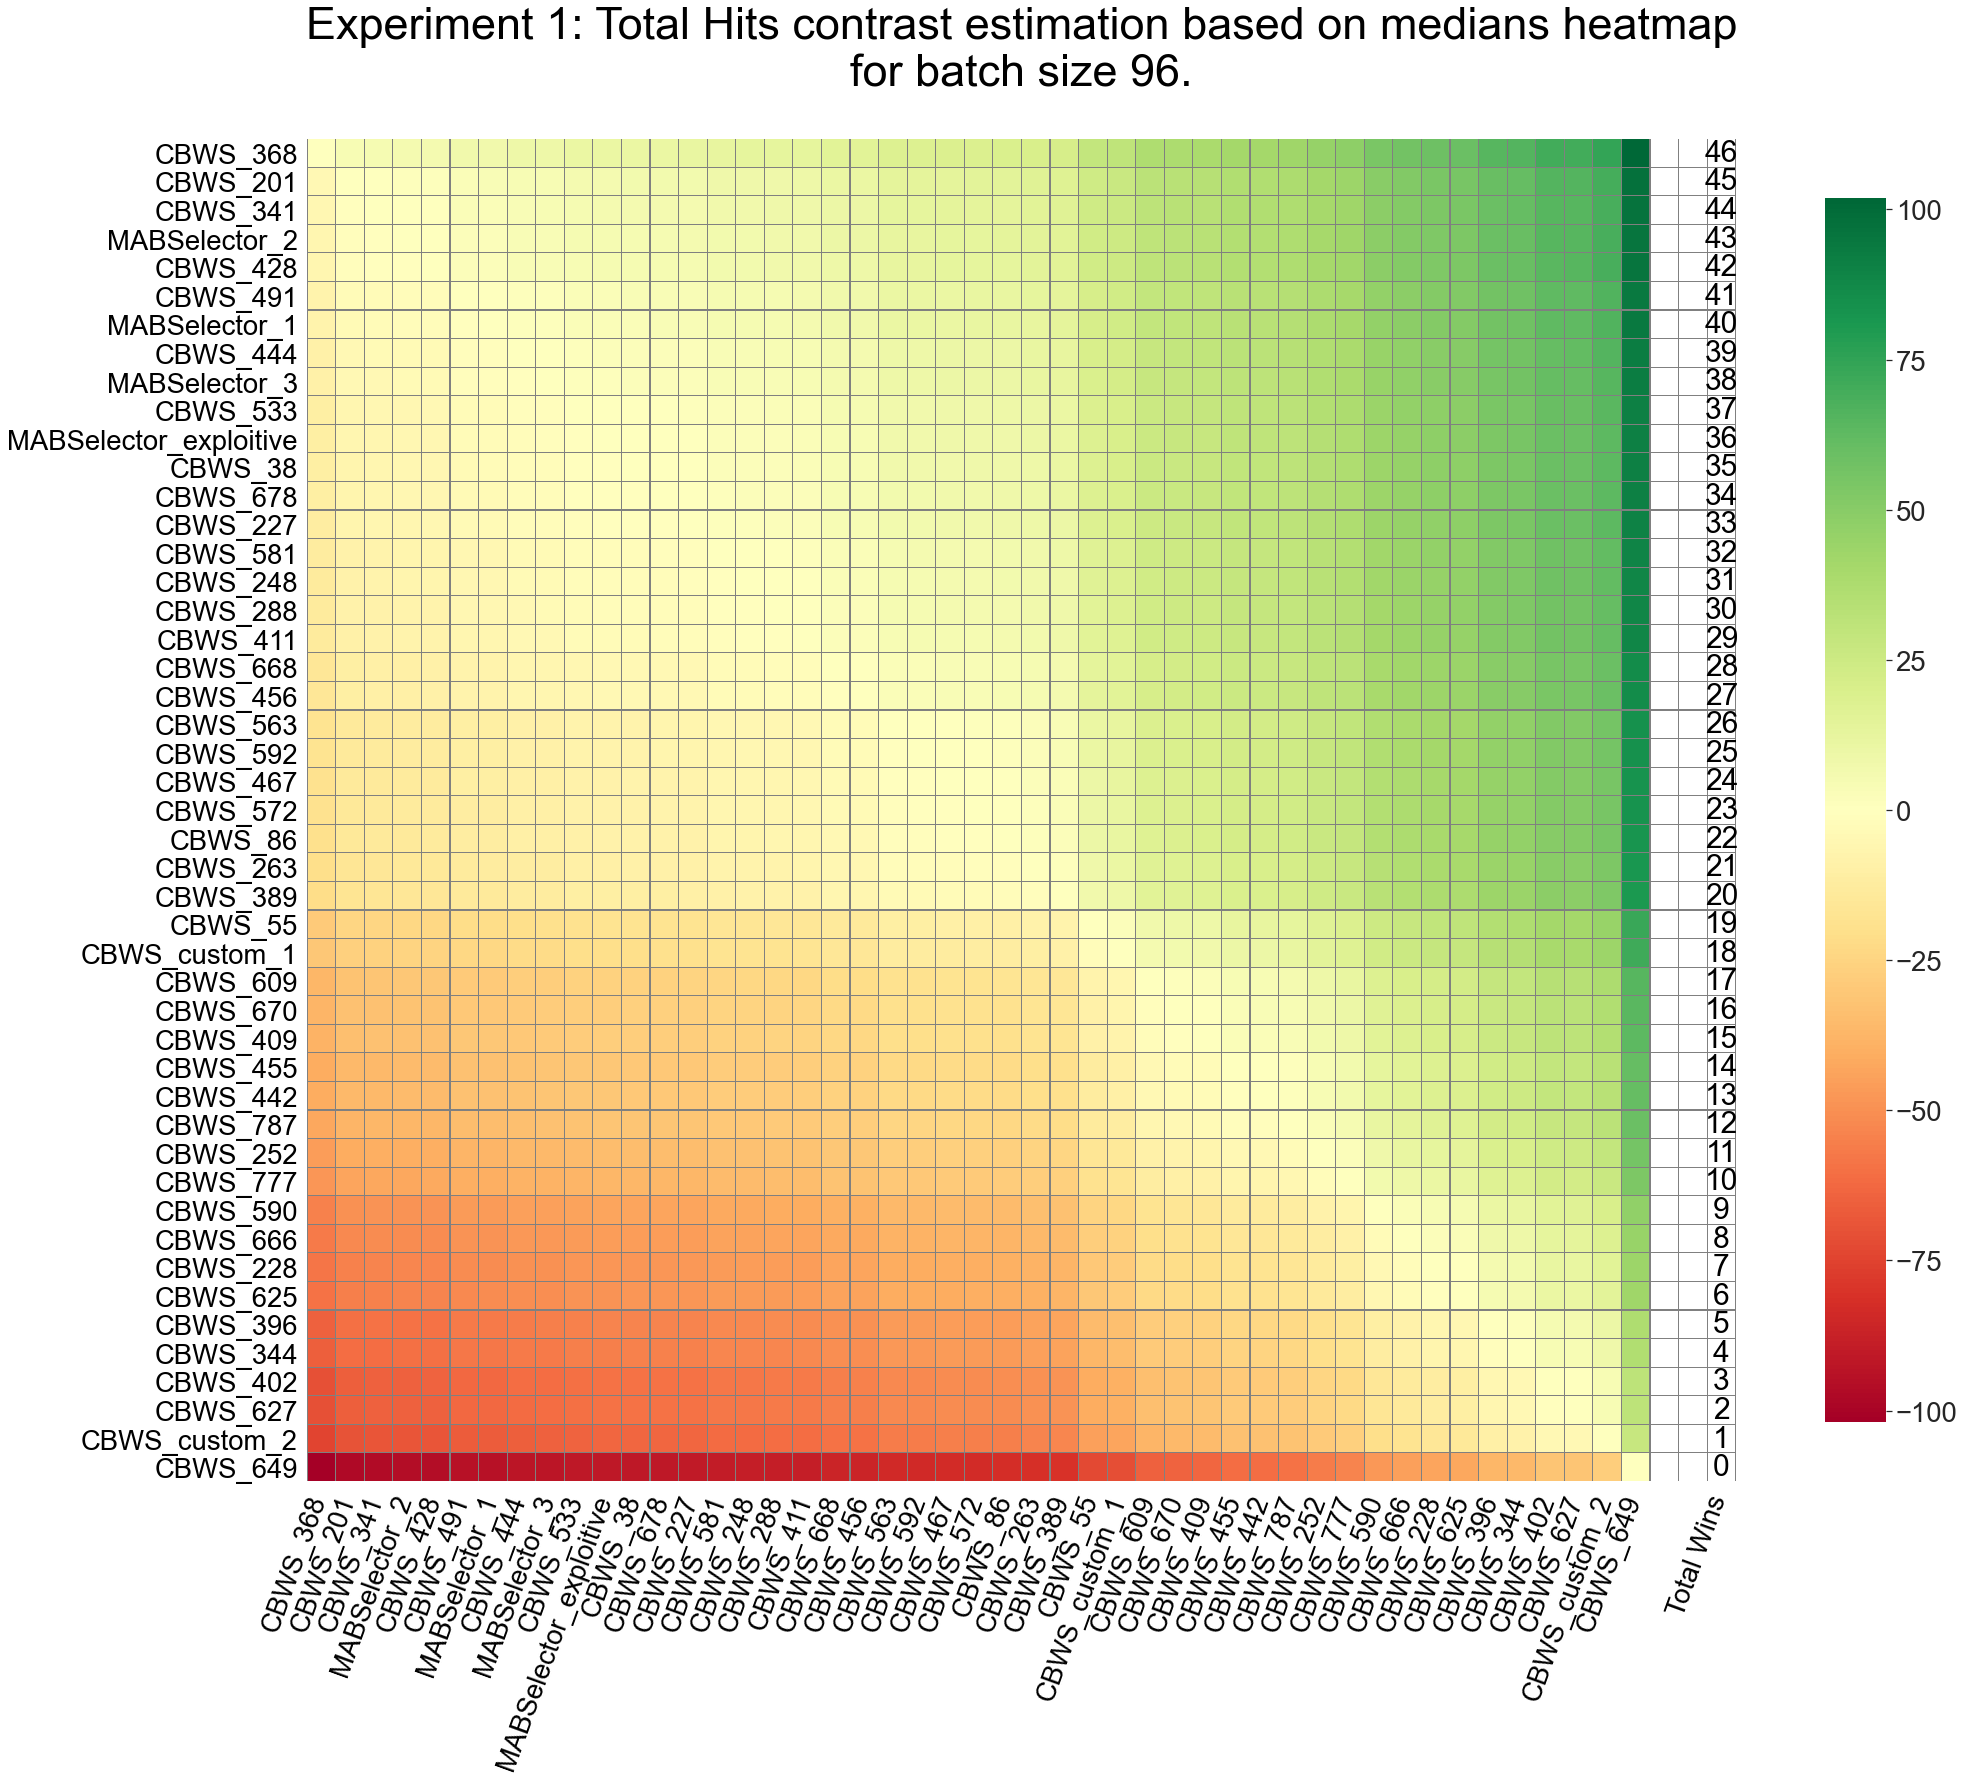

R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmp2xlNsN\filed6fc66b534e5', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Unique Hits Corrected Friedman's chi-squared statistic: 3.5984150005179765. DoF: 46.0. p-value: 2.1587176490811544e-12.


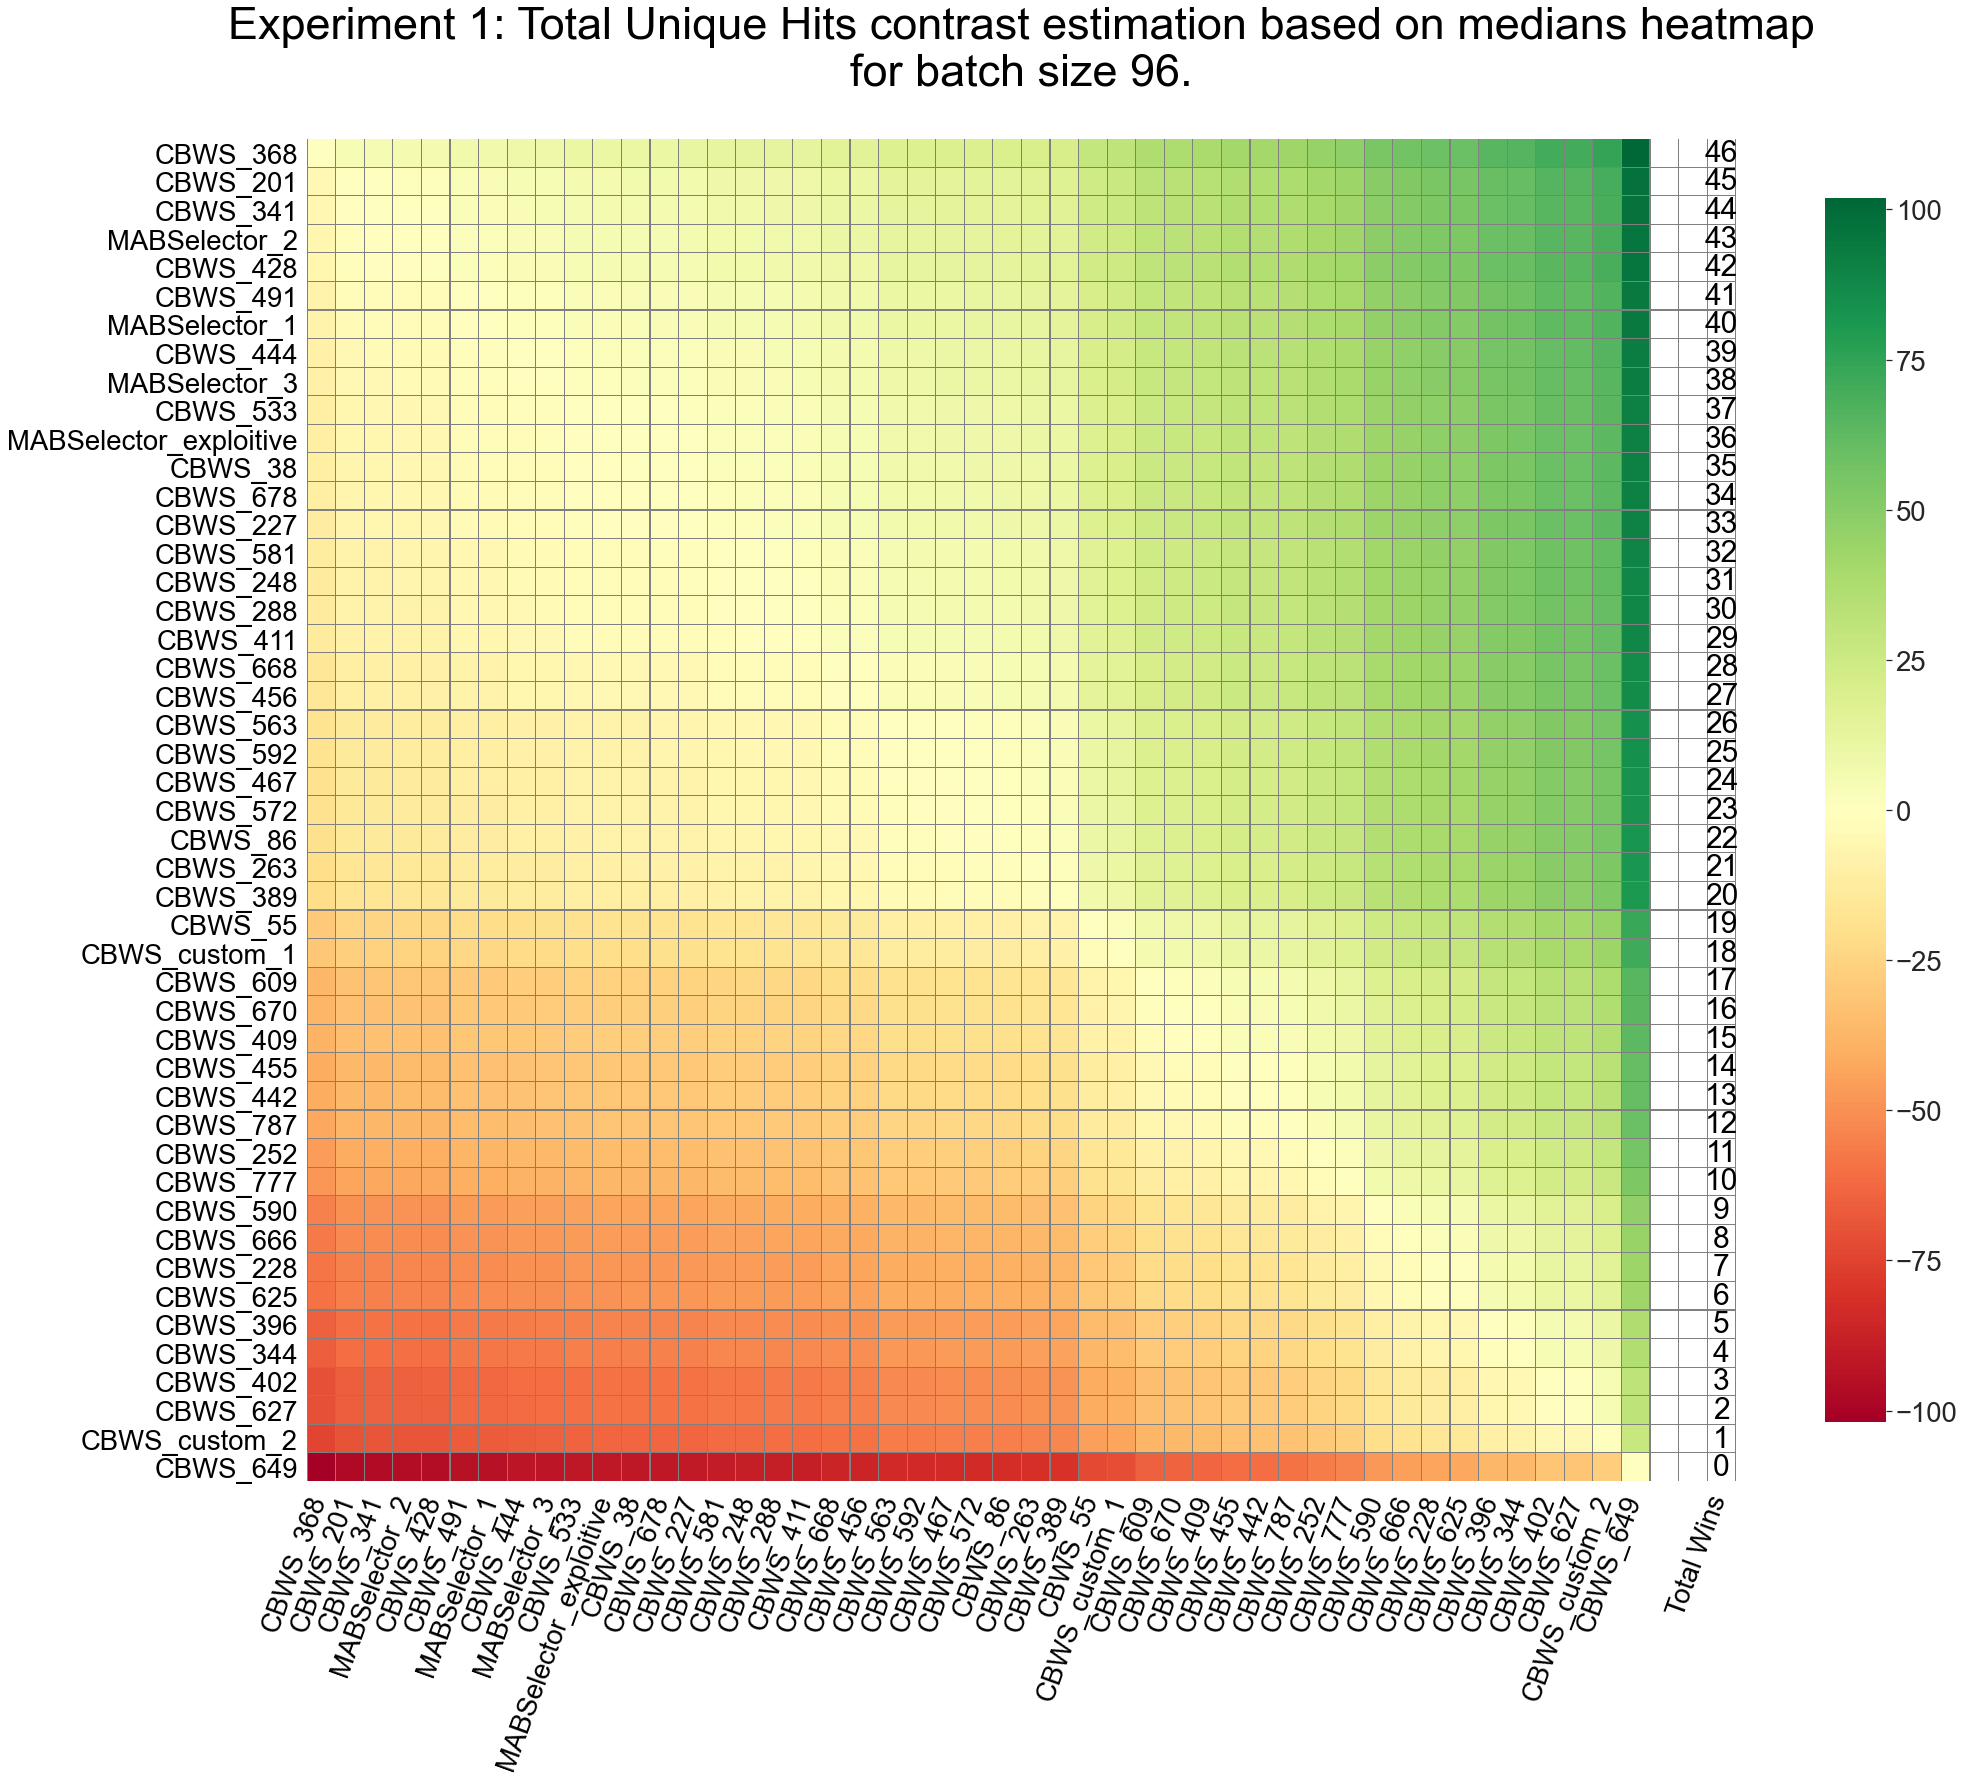

In [96]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2.5)
%load_ext autoreload
%autoreload 2

fontsize=45
metric='total_hits'
topk=47
corr_friedman_chisq, df1, pval = get_friedman_test(all_96_cs, all_96_bm, all_96_hs, metric, topk)
print('Total Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_hits_96_df, cem_wins_hits_96_df  = plot_cem_heatmap(all_96_cs, all_96_bm, all_96_hs, figsize=(30, 30),
                          title='Experiment 1: Total Hits contrast estimation based on medians heatmap\nfor batch size 96.',
                          metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)

metric='total_unique_hits'
topk=47
corr_friedman_chisq, df1, pval = get_friedman_test(all_96_cs, all_96_bm, all_96_hs, metric, topk)
print('Total Unique Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_uhits_96_df, cem_wins_uhits_96_df = plot_cem_heatmap(all_96_cs, all_96_bm, all_96_hs, figsize=(30, 30),
                              title='Experiment 1: Total Unique Hits contrast estimation based on medians heatmap\nfor batch size 96.',
                                      metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)

---

### Why are the strategies exploration heavy?

Looking at config of these top performers, we can see the reason for why some don't do exploitation. See overleaf document for full explanation, but the following is the summary:

To guarantee that some exploitation takes place every iteration (although this may not be the best strategy), then set \textbf{exploitation_use_quantile_for_activity} and \textbf{exploitation_use_quantile_for_weight} to true. 

Conceivably, these top performers may perform exploitation in later iterations when the model matures and the activity predictions are pushed to the edges.

In [10]:
import json 

top_k=15
temp_df = all_96.loc[cem_wins_hits_96_df.index.tolist()[:top_k]].drop_duplicates('hs_id')
top_15_cem = cem_wins_hits_96_df.index[:top_k].tolist()
config_df = pd.concat([pd.read_csv(x) for x in temp_df['config_file']]).reset_index(drop=True)
config_df['class'] = temp_df['hs_id'].reset_index(drop=True)
config_df.index = config_df['class']
temp_df = pd.concat([top_96_all.loc[top_15_cem][des_cols], config_df], axis=1)
temp_df = temp_df[['exploitation_hits_mean', 
       'exploitation_alpha', 
       'exploitation_activity_threshold', 
       'exploitation_weight_threshold',
       'exploitation_use_quantile_for_activity',
       'exploitation_use_quantile_for_weight',
       'hyperparameter_group', 'run_counts']].sort_values('exploitation_hits_mean')
temp_df

,exploitation_hits_mean,exploitation_alpha,exploitation_activity_threshold,exploitation_weight_threshold,exploitation_use_quantile_for_activity,exploitation_use_quantile_for_weight,hyperparameter_group,run_counts
CBWS_428,0.000000,0.5,0.50,0.50,True,False,top_384,9
CBWS_491,0.000000,0.0,0.75,1.00,False,False,top_1536,8
CBWS_678,0.000000,0.5,0.25,0.50,True,False,top_96,8
CBWS_227,0.000000,0.5,0.75,0.75,True,False,top_1536,6
CBWS_201,0.400000,1.0,0.75,0.75,False,True,top_1536,10
CBWS_533,1.375000,1.0,0.25,0.75,False,False,top_1536,8
CBWS_444,11.888889,1.0,0.75,0.75,False,False,top_1536,9
CBWS_341,17.444444,1.0,0.75,0.75,True,False,top_96,9
CBWS_368,45.600000,0.5,0.75,0.25,True,False,top_96,10
MABSelector_3,108.300000,NaN,NaN,NaN,NaN,NaN,benchmark,10


---
# Top models for batch_size=384

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


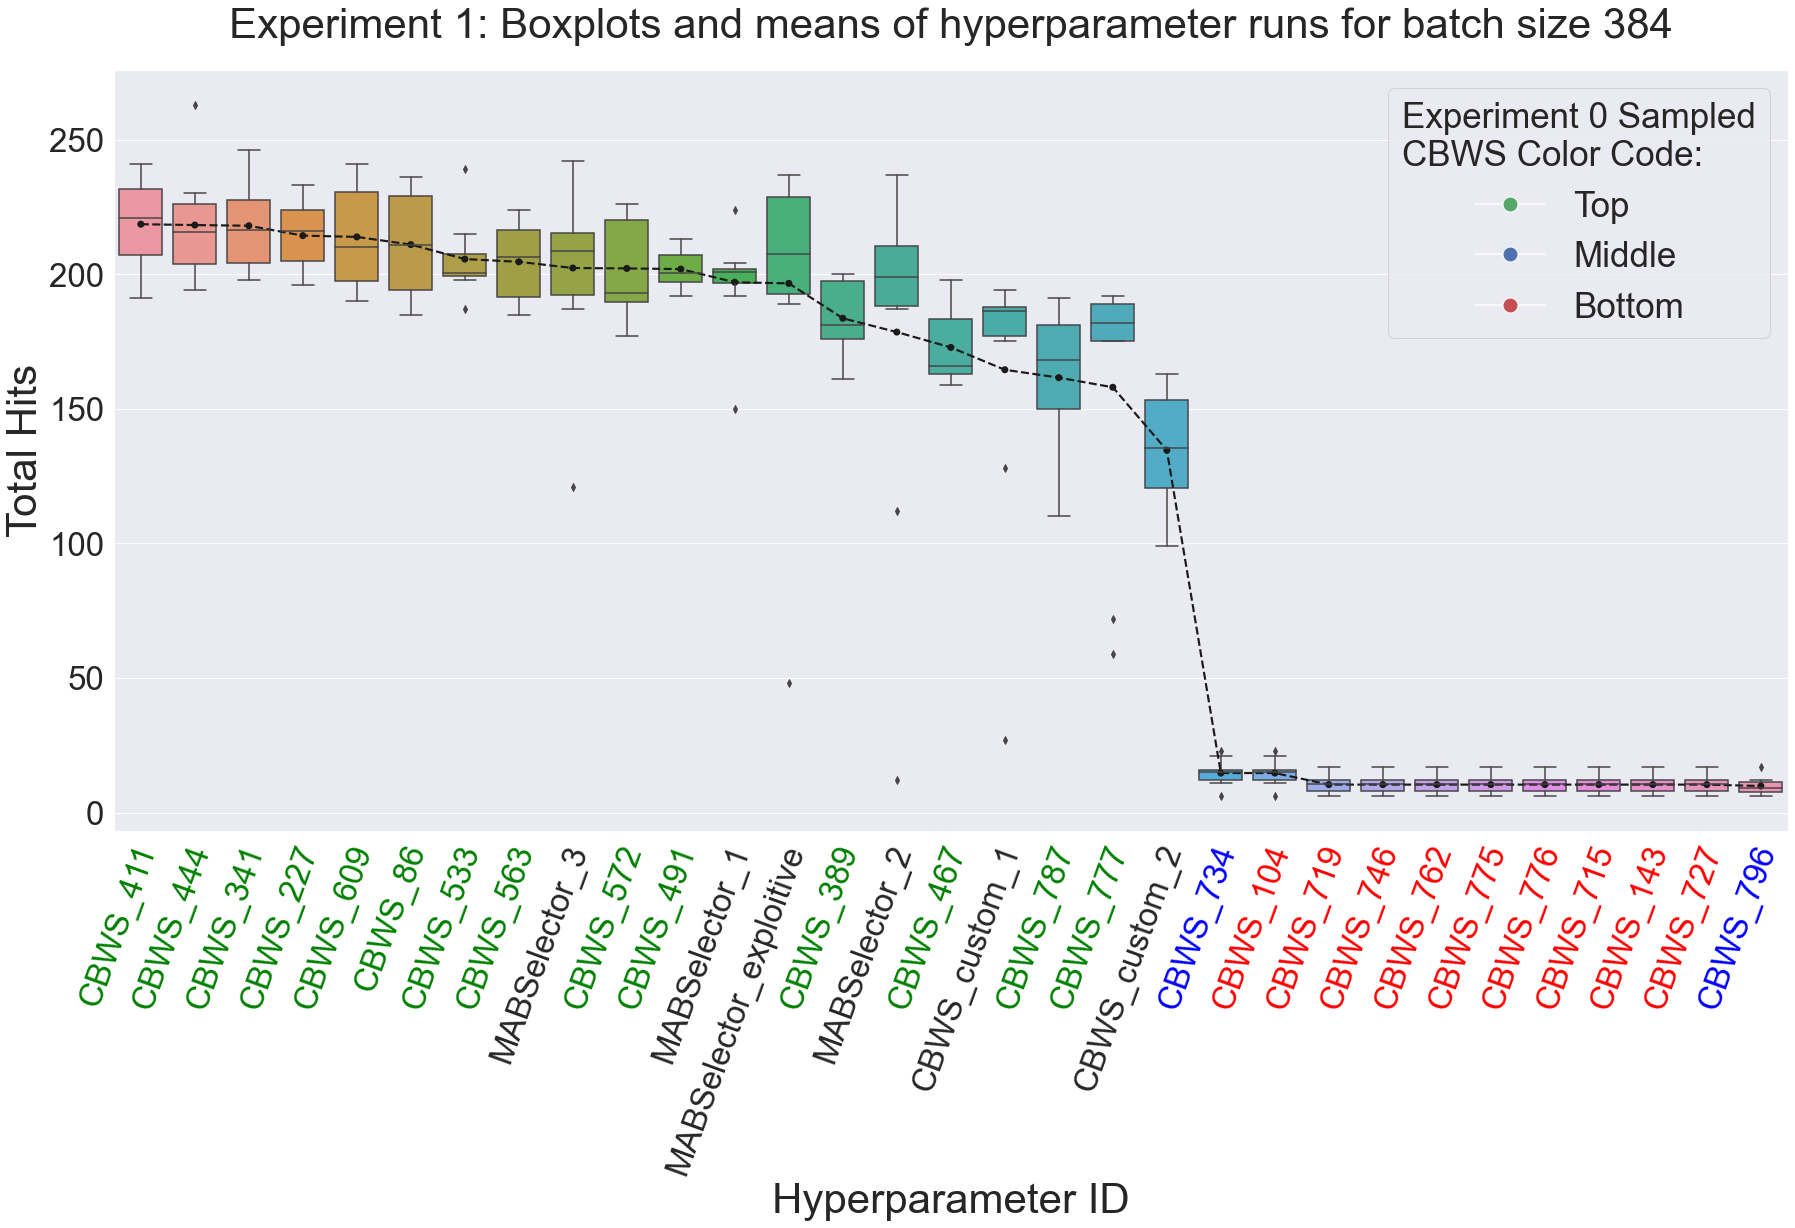

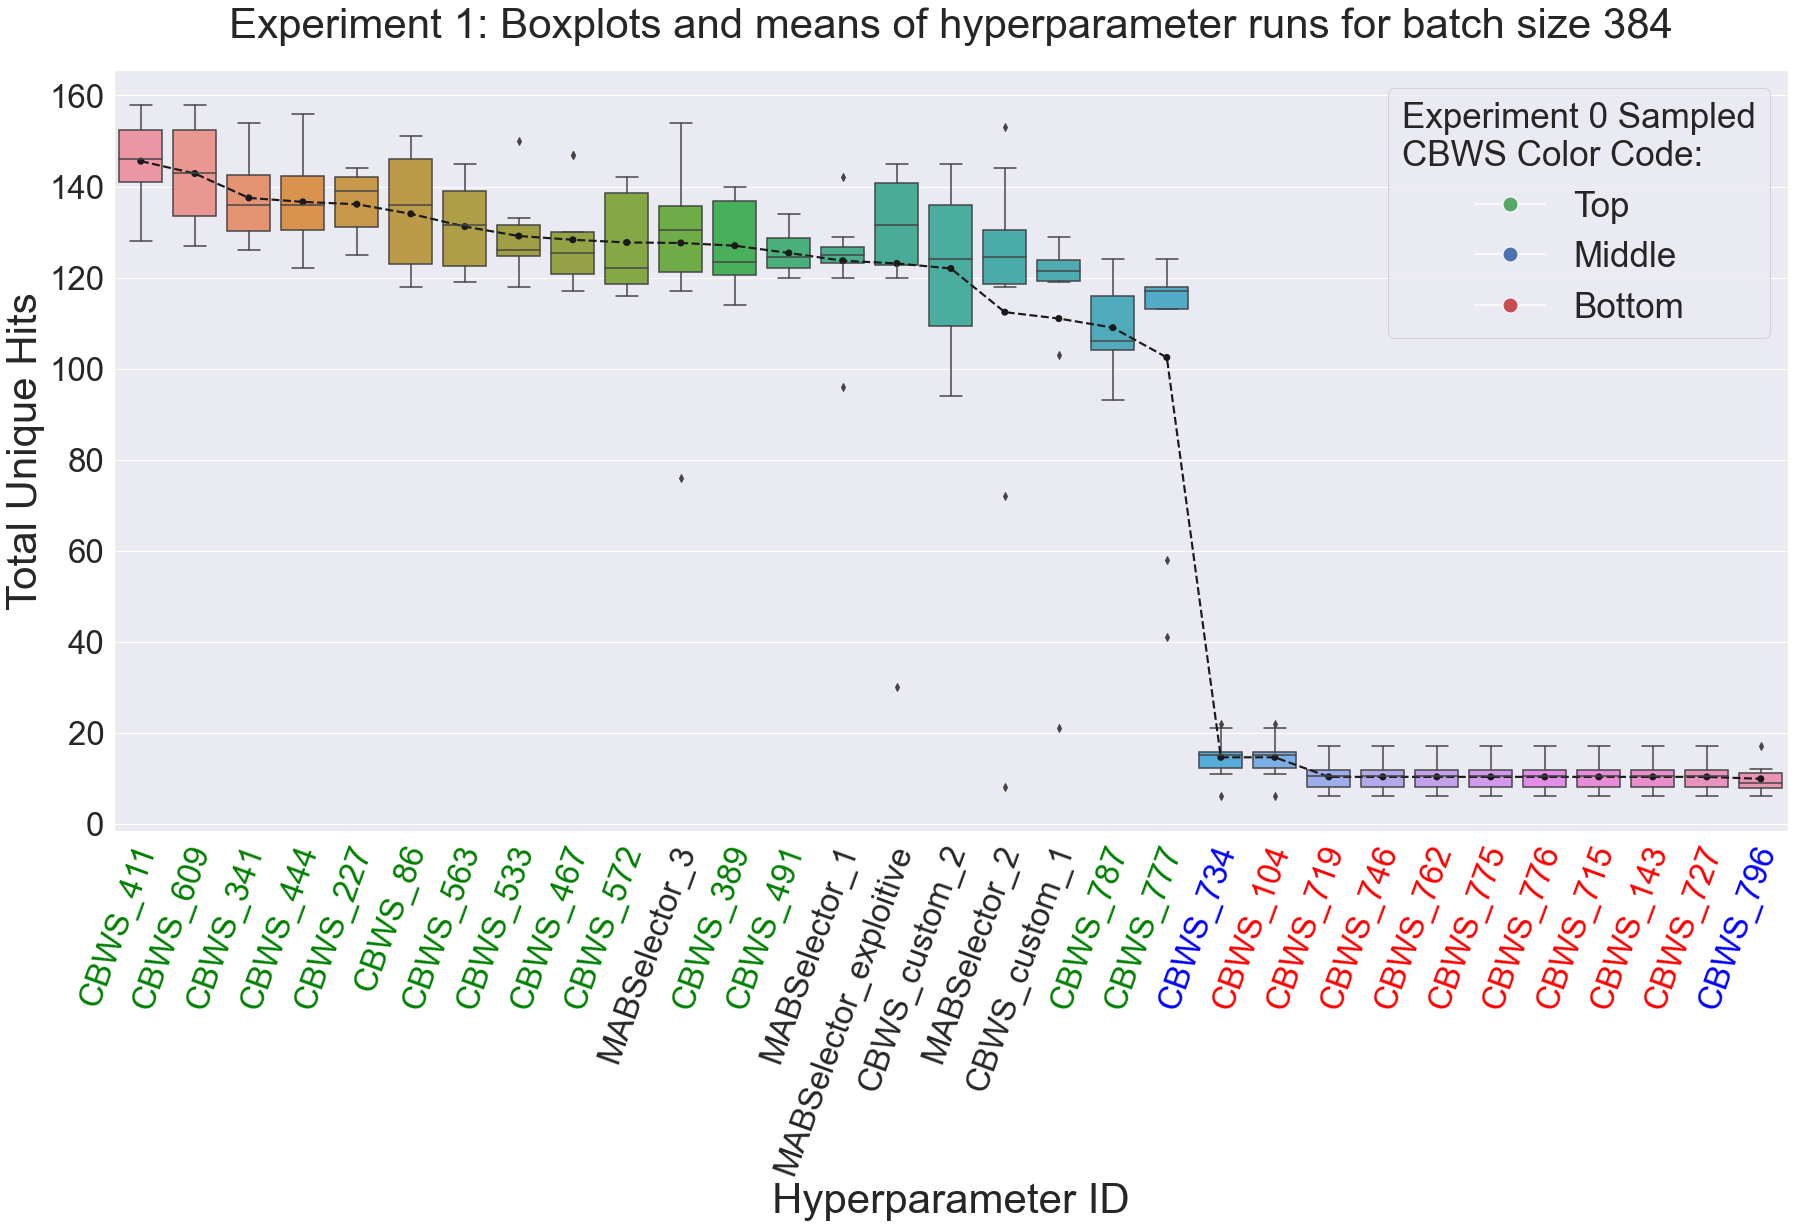

In [86]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_384_hs = get_top_summary(all_384_hs)
top_384_bm = get_top_summary(all_384_bm)
top_384_cs = get_top_summary(all_384_cs)

from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=3.0)
%load_ext autoreload
%autoreload 2

fontsize=42
all_384 = pd.concat([all_384_cs, all_384_bm, all_384_hs])
top_384_all = pd.concat([top_384_cs, top_384_bm, top_384_hs])
plot_boxplots_simple(all_384, top_384_all, metric_col_box='total_hits', metric_col_point='total_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 384',
                     xlabel='Hyperparameter ID', ylabel='Total Hits', isExp1=True, fontsize=fontsize)

plot_boxplots_simple(all_384, top_384_all, metric_col_box='total_unique_hits', metric_col_point='total_unique_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 384',
                     xlabel='Hyperparameter ID', ylabel='Total Unique Hits', isExp1=True, fontsize=fontsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmp2xlNsN\filed6fc28422083', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Hits Corrected Friedman's chi-squared statistic: 4.673905345046217. DoF: 19.0. p-value: 1.3732432968538433e-08.


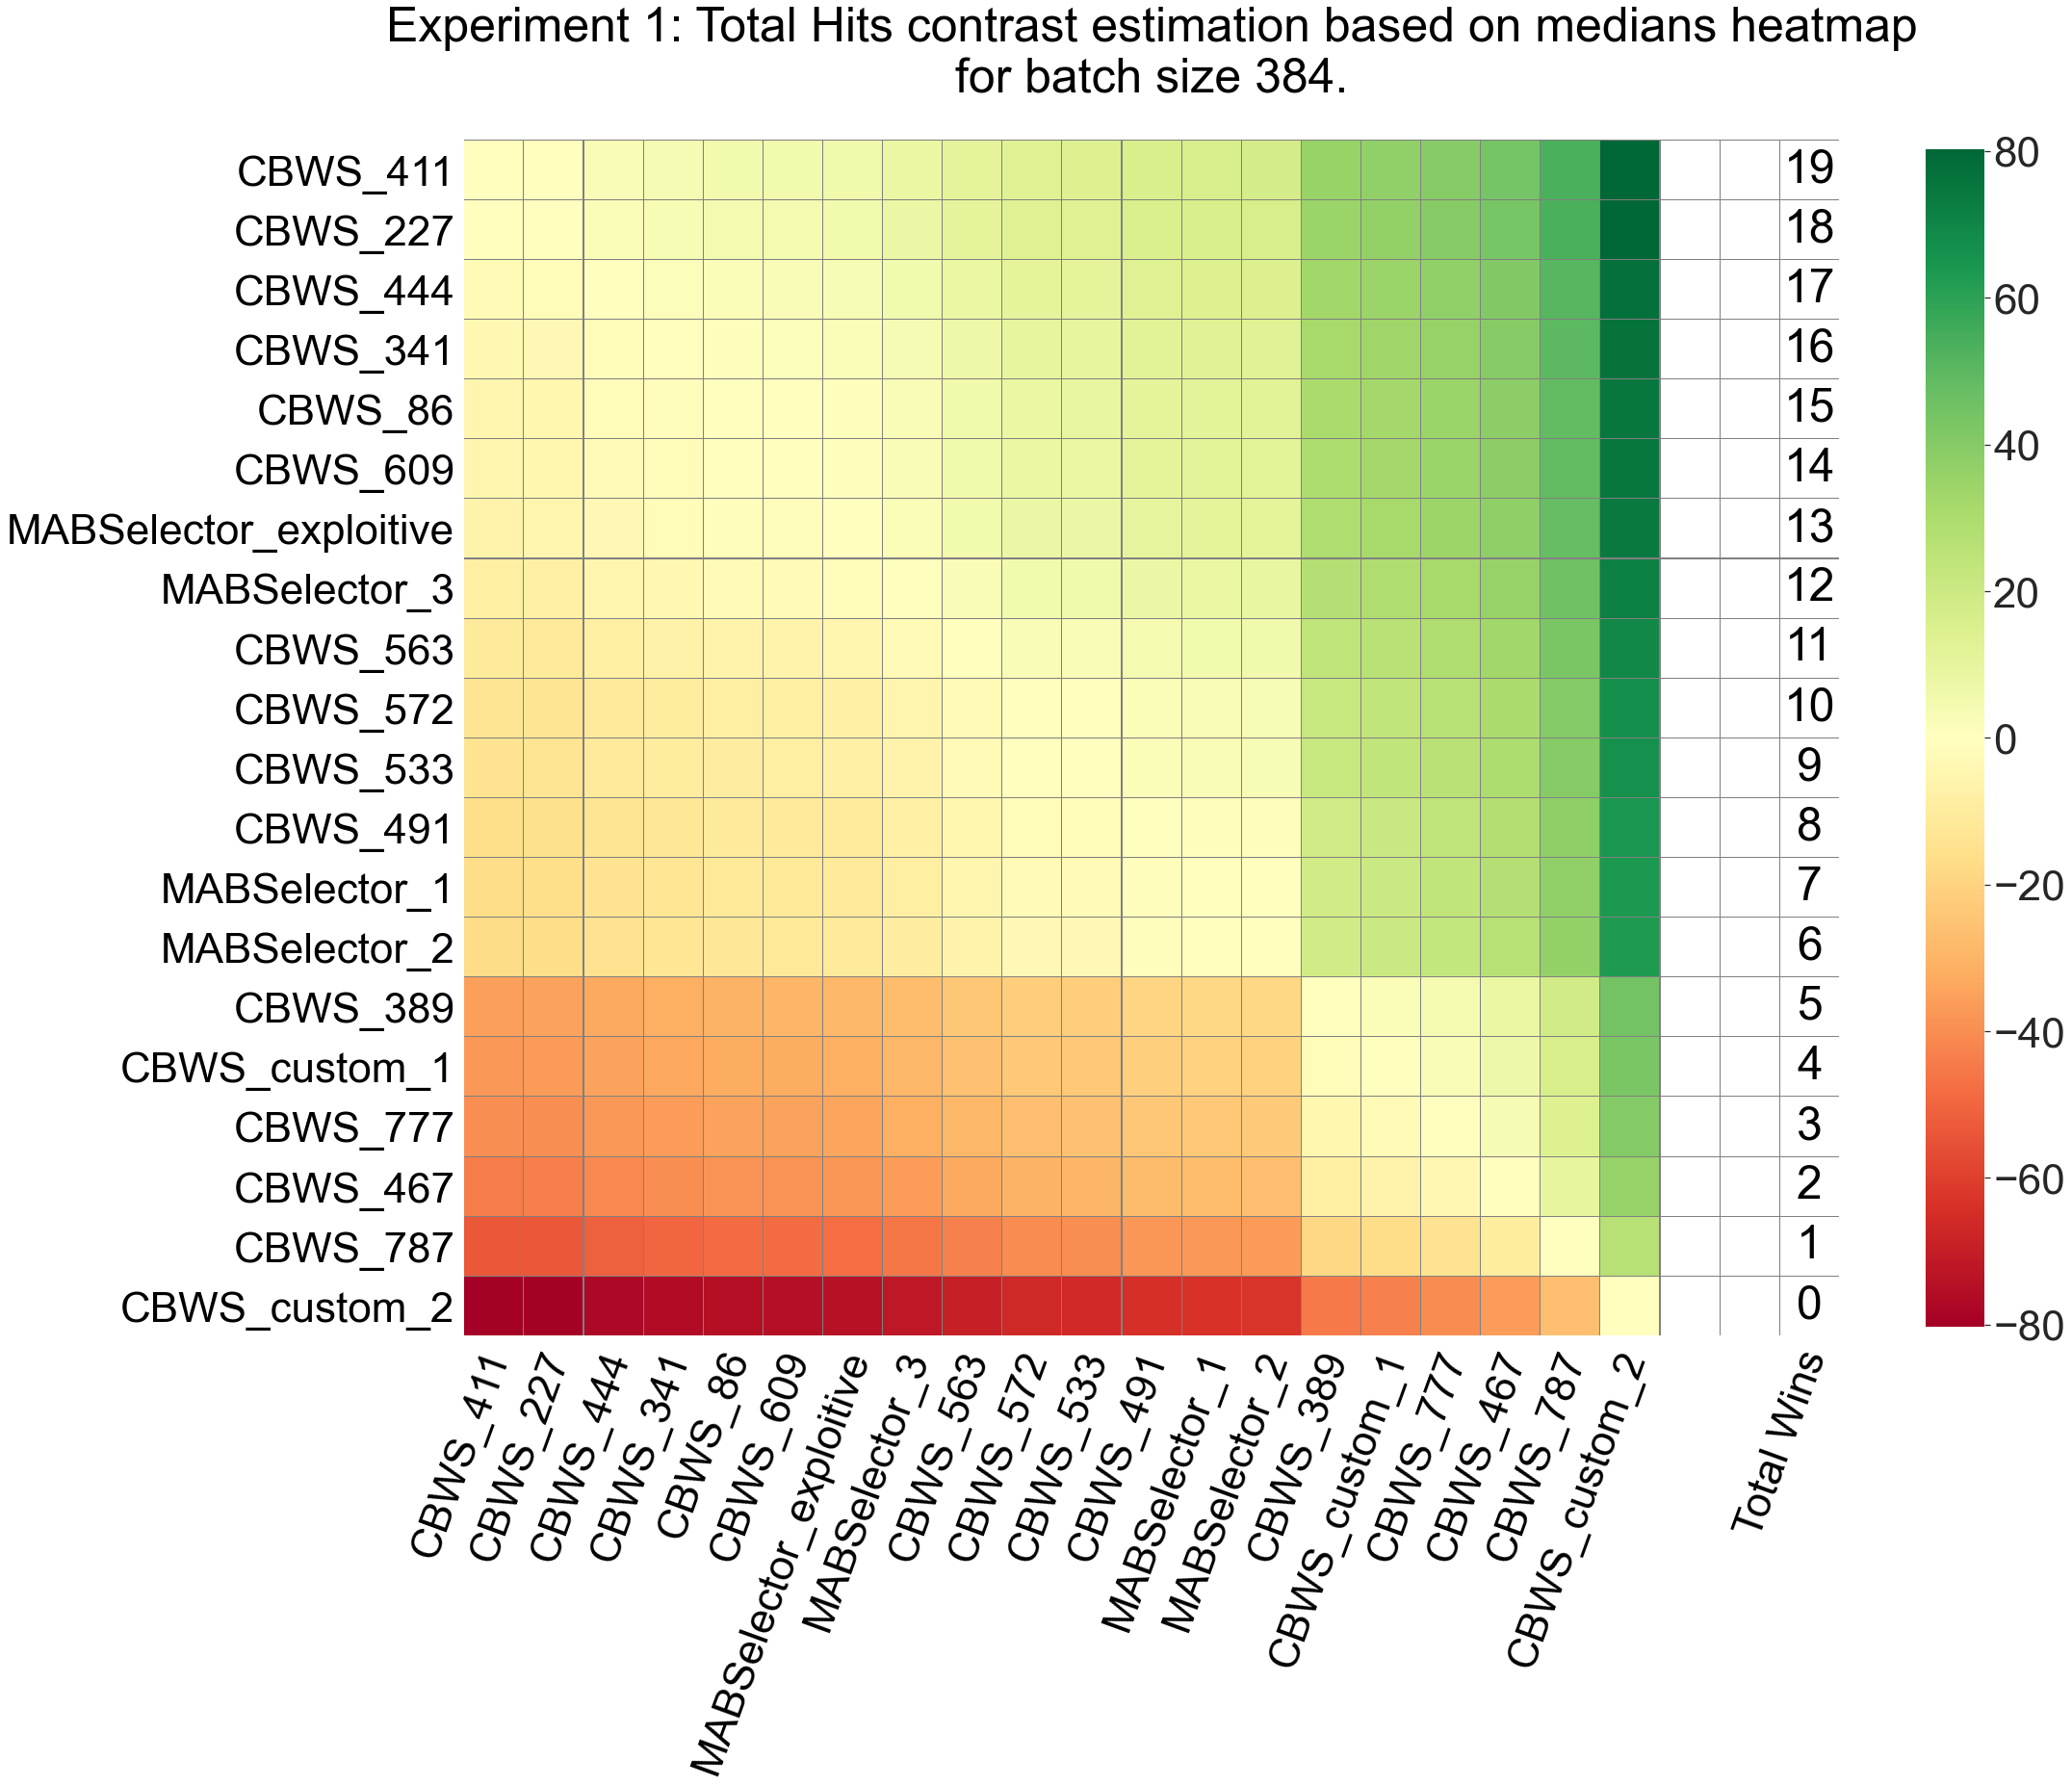

R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmp2xlNsN\filed6fc70f24810', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Unique Hits Corrected Friedman's chi-squared statistic: 2.5653291336148194. DoF: 19.0. p-value: 0.0006963093441849644.


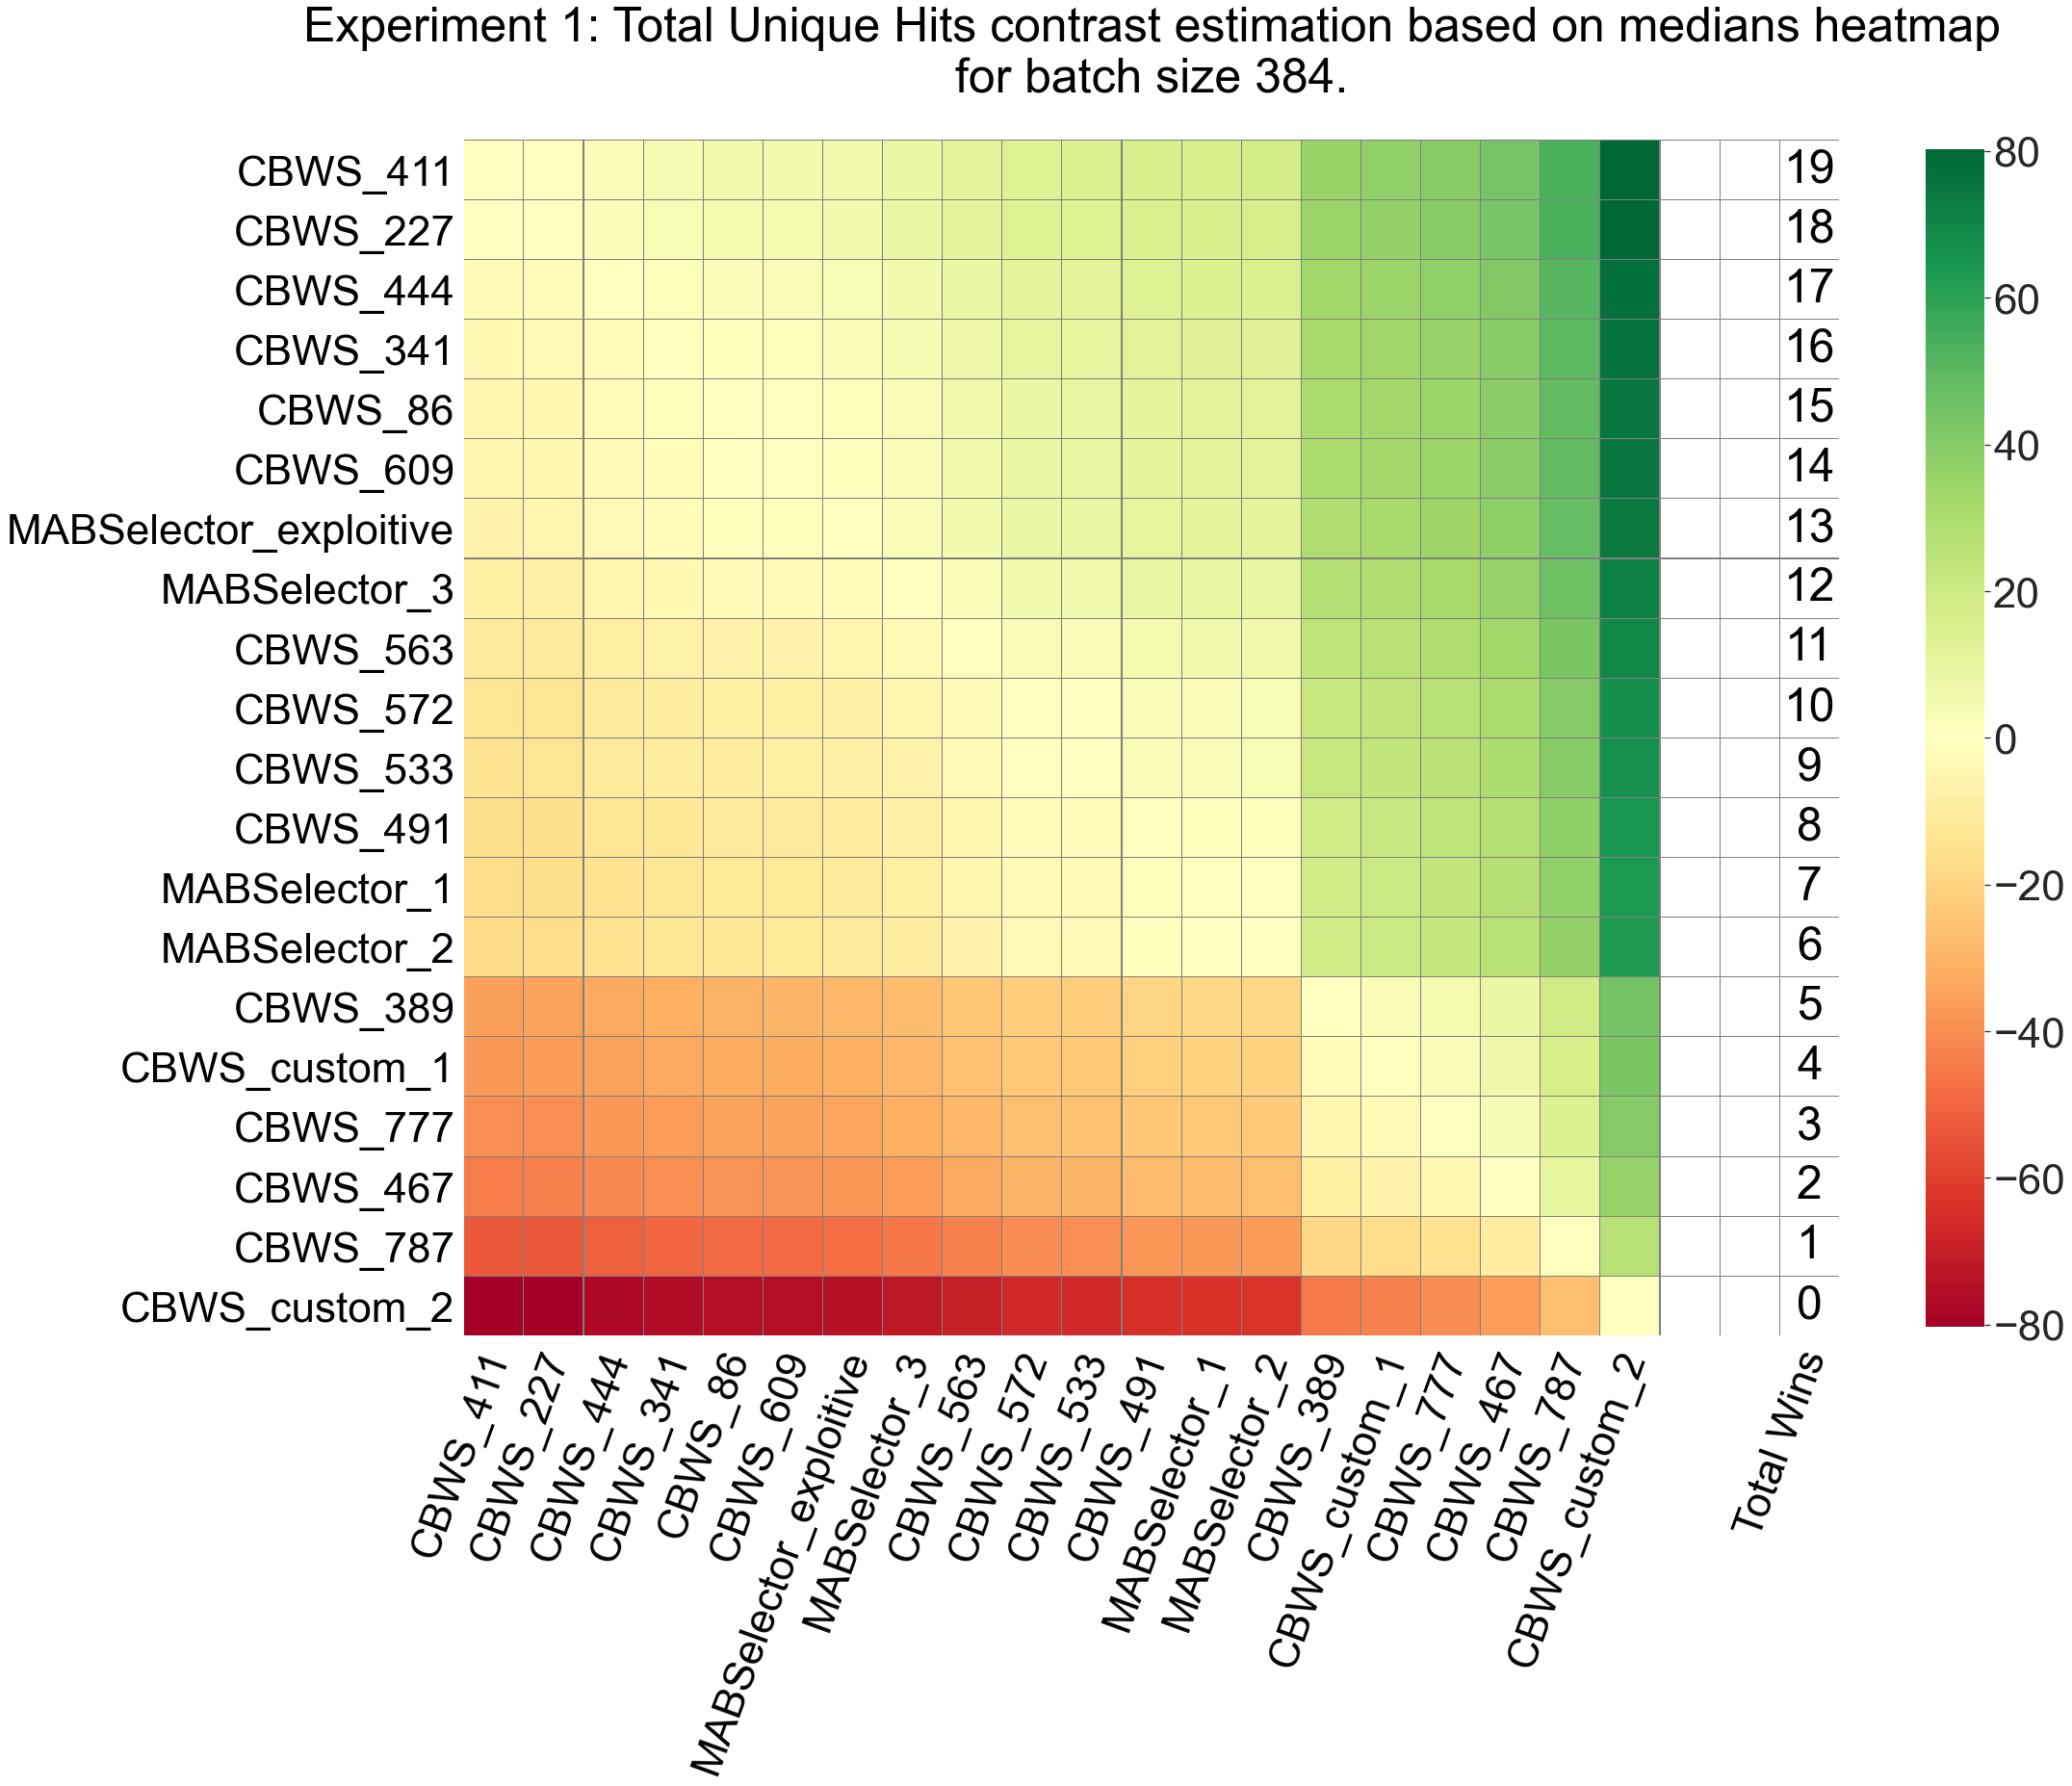

In [95]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=4.0)
%load_ext autoreload
%autoreload 2

fontsize=50
metric='total_hits'
topk=20
corr_friedman_chisq, df1, pval = get_friedman_test(all_384_cs, all_384_bm, all_384_hs, metric, topk)
print('Total Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_hits_384_df, cem_wins_hits_384_df = plot_cem_heatmap(all_384_cs, all_384_bm, all_384_hs, figsize=(30, 30),
                          title='Experiment 1: Total Hits contrast estimation based on medians heatmap\nfor batch size 384.',
                          metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)

metric='total_unique_hits'
topk=20
corr_friedman_chisq, df1, pval = get_friedman_test(all_384_cs, all_384_bm, all_384_hs, metric, topk)
print('Total Unique Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_uhits_384_df, cem_wins_uhits_384_df = plot_cem_heatmap(all_384_cs, all_384_bm, all_384_hs, figsize=(30, 30),
                          title='Experiment 1: Total Unique Hits contrast estimation based on medians heatmap\nfor batch size 384.',
                          metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)

---
# Top models for batch_size=1536

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


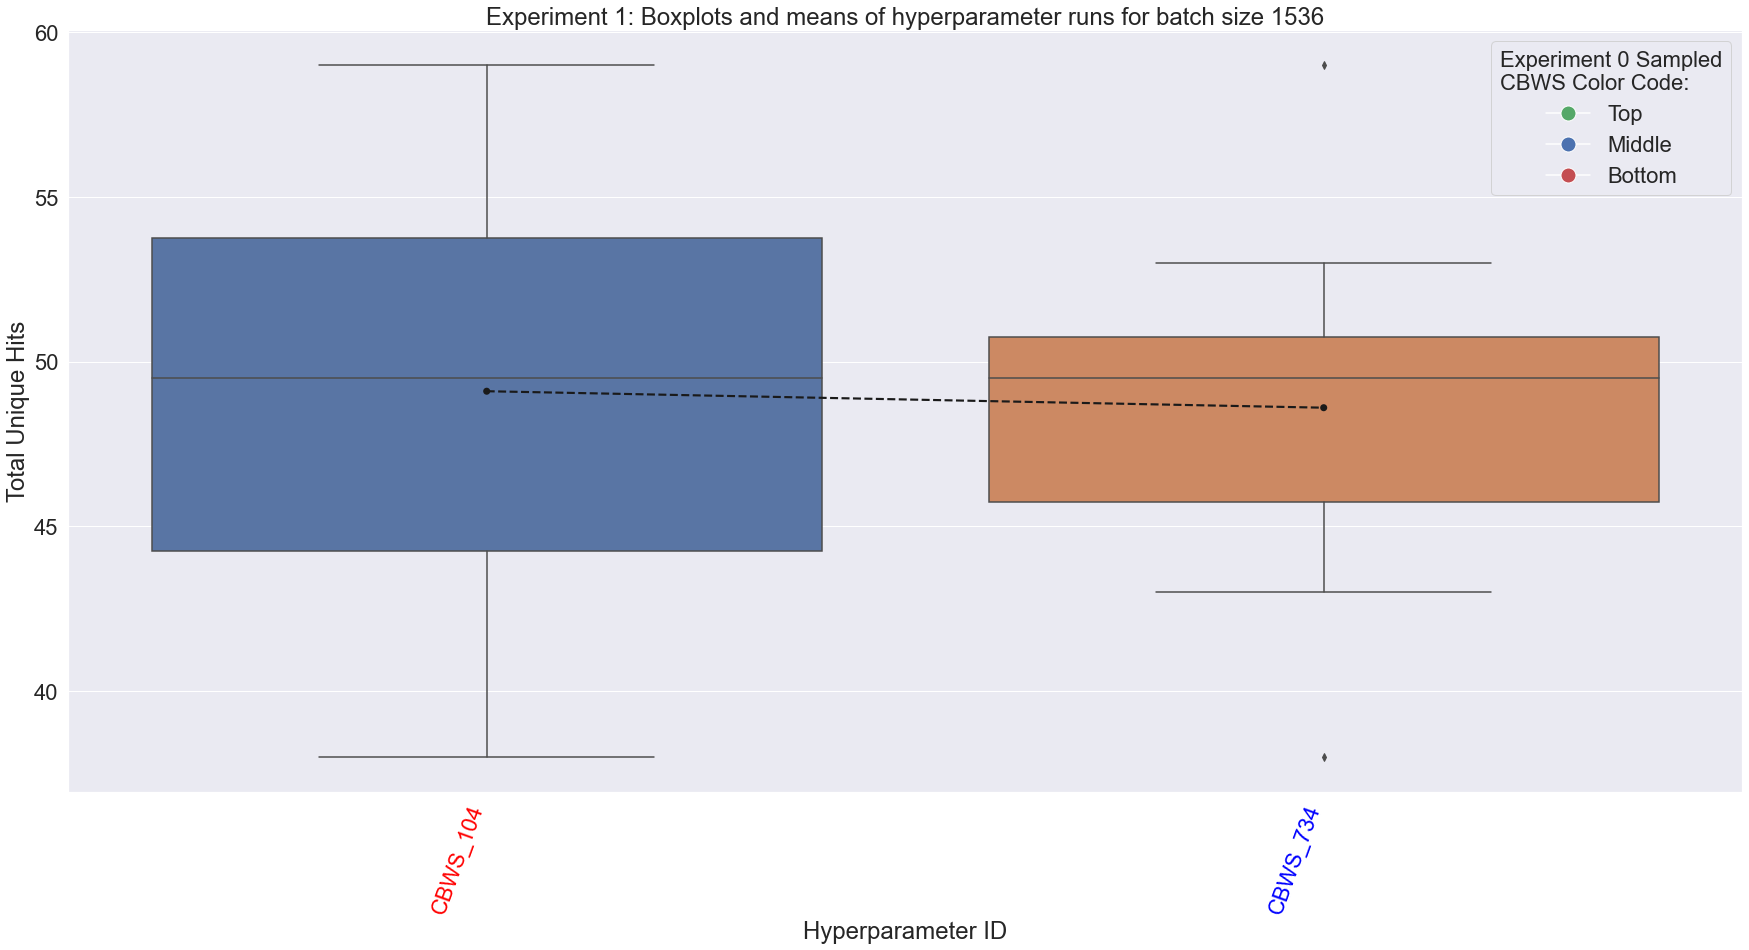

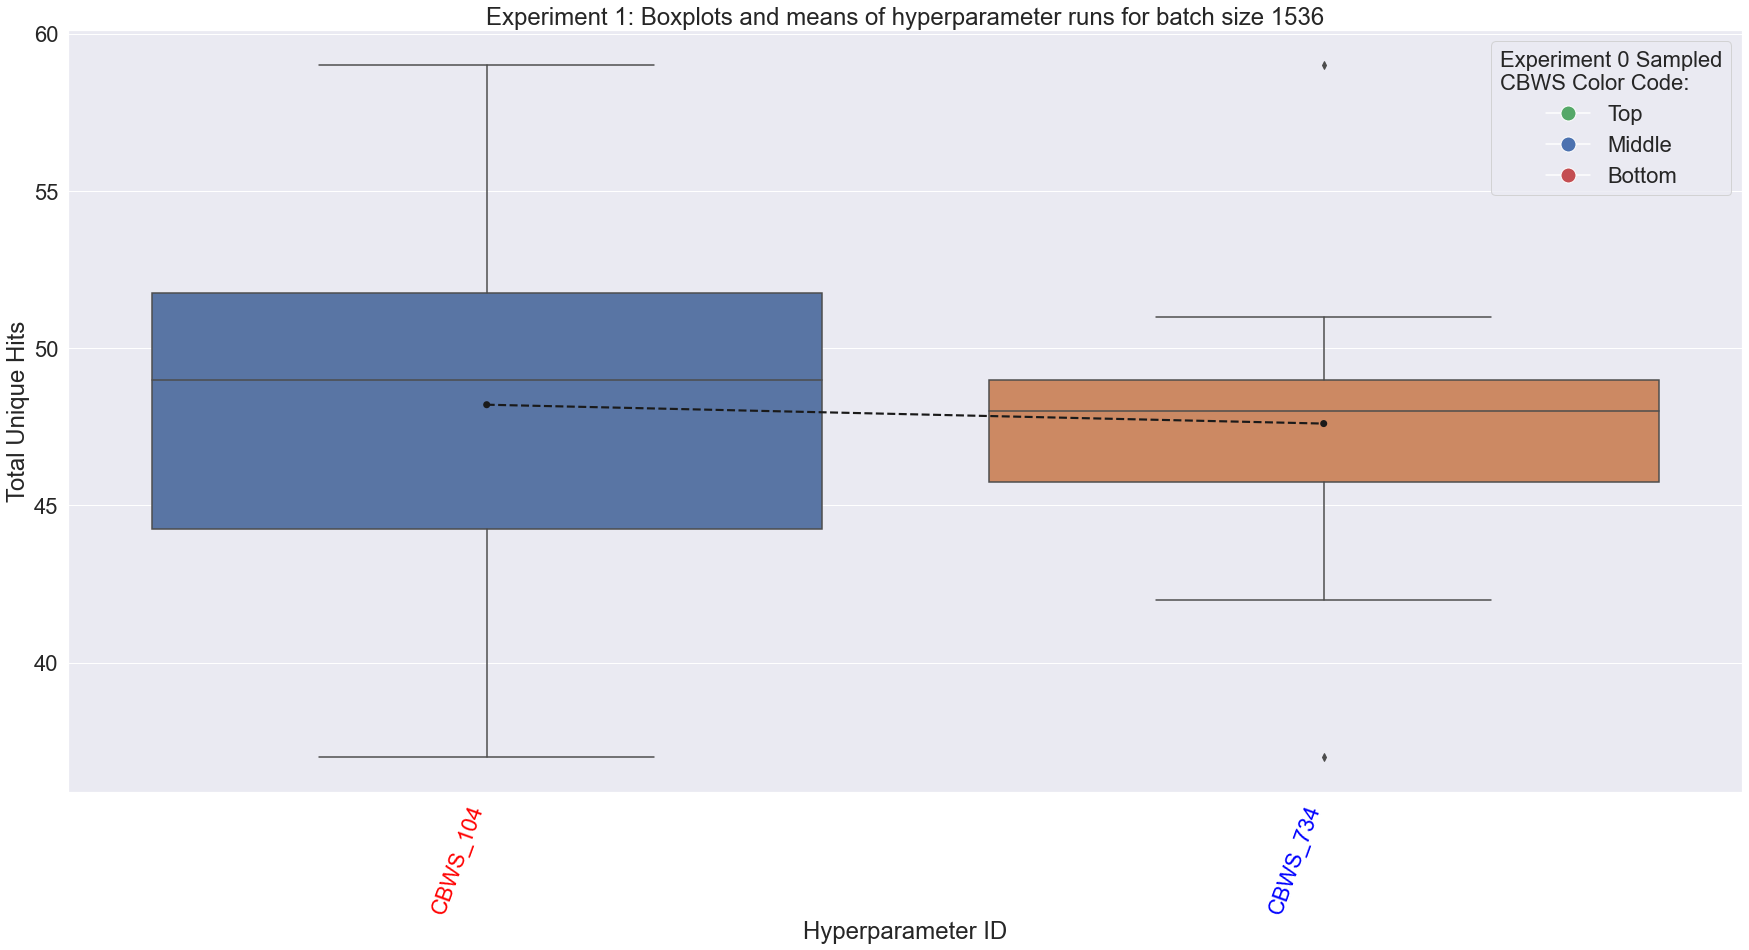

In [25]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_1536_hs = get_top_summary(all_1536_hs)
top_1536_bm = get_top_summary(all_1536_bm)
top_1536_cs = None
#top_1536_cs = get_top_summary(all_1536_cs)

from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2)
%load_ext autoreload
%autoreload 2

all_1536 = pd.concat([all_1536_cs, all_1536_bm, all_1536_hs])
top_1536_all = pd.concat([top_1536_cs, top_1536_bm, top_1536_hs])
plot_boxplots_simple(all_1536, top_1536_all, metric_col_box='total_hits', metric_col_point='total_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 1536',
                     xlabel='Hyperparameter ID', ylabel='Total Unique Hits', isExp1=True)
plot_boxplots_simple(all_1536, top_1536_all, metric_col_box='total_unique_hits', metric_col_point='total_unique_hits_mean',
                     title='Experiment 1: Boxplots and means of hyperparameter runs for batch size 1536',
                     xlabel='Hyperparameter ID', ylabel='Total Unique Hits', isExp1=True)

---
# Overlap of top performers across batch size

In [26]:
cem_wins_hits_96_df[:16]

CBWS_368                  46
CBWS_201                  45
CBWS_341                  44
MABSelector_2             43
CBWS_428                  42
CBWS_491                  41
MABSelector_1             40
CBWS_444                  39
MABSelector_3             38
CBWS_533                  37
MABSelector_exploitive    36
CBWS_38                   35
CBWS_678                  34
CBWS_227                  33
CBWS_581                  32
CBWS_248                  31
Name: Total Wins total_hits, dtype: int64

In [27]:
cem_wins_uhits_96_df[:16]

CBWS_368                  46
CBWS_201                  45
CBWS_341                  44
MABSelector_2             43
CBWS_428                  42
CBWS_491                  41
MABSelector_1             40
CBWS_444                  39
MABSelector_3             38
CBWS_533                  37
MABSelector_exploitive    36
CBWS_38                   35
CBWS_678                  34
CBWS_227                  33
CBWS_581                  32
CBWS_248                  31
Name: Total Wins total_unique_hits, dtype: int64

In [28]:
cem_wins_hits_384_df[:16]

CBWS_411                  19
CBWS_227                  18
CBWS_444                  17
CBWS_341                  16
CBWS_86                   15
CBWS_609                  14
MABSelector_exploitive    13
MABSelector_3             12
CBWS_563                  11
CBWS_572                  10
CBWS_533                   9
CBWS_491                   8
MABSelector_1              7
MABSelector_2              6
CBWS_389                   5
CBWS_custom_1              4
Name: Total Wins total_hits, dtype: int64

In [29]:
cem_wins_uhits_384_df[:16]

CBWS_411                  19
CBWS_227                  18
CBWS_444                  17
CBWS_341                  16
CBWS_86                   15
CBWS_609                  14
MABSelector_exploitive    13
MABSelector_3             12
CBWS_563                  11
CBWS_572                  10
CBWS_533                   9
CBWS_491                   8
MABSelector_1              7
MABSelector_2              6
CBWS_389                   5
CBWS_custom_1              4
Name: Total Wins total_unique_hits, dtype: int64

### Selection for experiment 2
This gives four criteria for promotion: top 15 strategies based on total hits CEM wins for batch size 96, top 15 strategies based on total unique hits CEM wins for batch size 96, top 15 strategies based on total hits CEM wins for batch size 384, and top 15 strategies based on total unique hits CEM wins for batch size 384. 

Promoted strategies:
- 12 sampled CBWS strategies: CBWS\_201, CBWS\_341, CBWS\_368, CBWS\_396, CBWS\_411, CBWS\_467, CBWS\_55, CBWS\_581, CBWS\_590, CBWS\_609, CBWS\_625, and CBWS\_678. 
- 2 Benchmarks: MABSelector_2, and MABSelector_3
- 3 custom CBWS strategies: CBWS\_custom\_1, CBWS\_custom\_2, InstanceBWS\_custom\_0. 
    Note that InstanceBWS\_custom\_0 did not finish successfully in experiment 1 but we still include it for the next experiment.

Total of 12 + 2 + 3 = 17 strategies to be run on experiment 2.

In [ ]:
a, b = cem_wins_hits_96_df[:8].index.tolist(), cem_wins_uhits_96_df[:8].index.tolist()
c, d = cem_wins_hits_384_df[:8].index.tolist(), cem_wins_uhits_384_df[:8].index.tolist()

x, c = np.unique(a+b+c+d, return_counts=True)
idx_sort = np.argsort(c)[::-1]
x[idx_sort], c[idx_sort]

In [ ]:
exp_2_strats = ['MABSelector_2', 'MABSelector_3',
                 'ClusterBasedWCSelector_custom_1',
                 'ClusterBasedWCSelector_201', 'ClusterBasedWCSelector_341', 'ClusterBasedWCSelector_368', 'ClusterBasedWCSelector_396',
                 'ClusterBasedWCSelector_411', 'ClusterBasedWCSelector_467', 'ClusterBasedWCSelector_55', 'ClusterBasedWCSelector_581',
                 'ClusterBasedWCSelector_590', 'ClusterBasedWCSelector_609', 'ClusterBasedWCSelector_625', 'ClusterBasedWCSelector_678']

", ".join([x.replace('ClusterBasedWCSelector', 'CBWS') for x in exp_2_strats])

In [ ]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean',
       'total_hits_std', 'total_unique_hits_mean', 'total_unique_hits_std', 'run_counts', 'hs_group']

tmp_df = top_96_all.copy()
tmp_df.index = [x.replace('ClusterBasedWCSelector', 'CBWS') for x in tmp_df.index]
tmp_df = tmp_df[des_cols].sort_values('total_hits_mean', ascending=False).round(decimals=2)
print(tmp_df.to_latex(longtable=True))

In [ ]:
tmp_df = top_384_all.copy()
tmp_df.index = [x.replace('ClusterBasedWCSelector', 'CBWS') for x in tmp_df.index]
tmp_df = tmp_df[des_cols].sort_values('total_hits_mean', ascending=False).round(decimals=2)
print(tmp_df.to_latex(longtable=True))